Identified class: background
Identified class: drink
Identified class: snack
Identified class: Human_hand


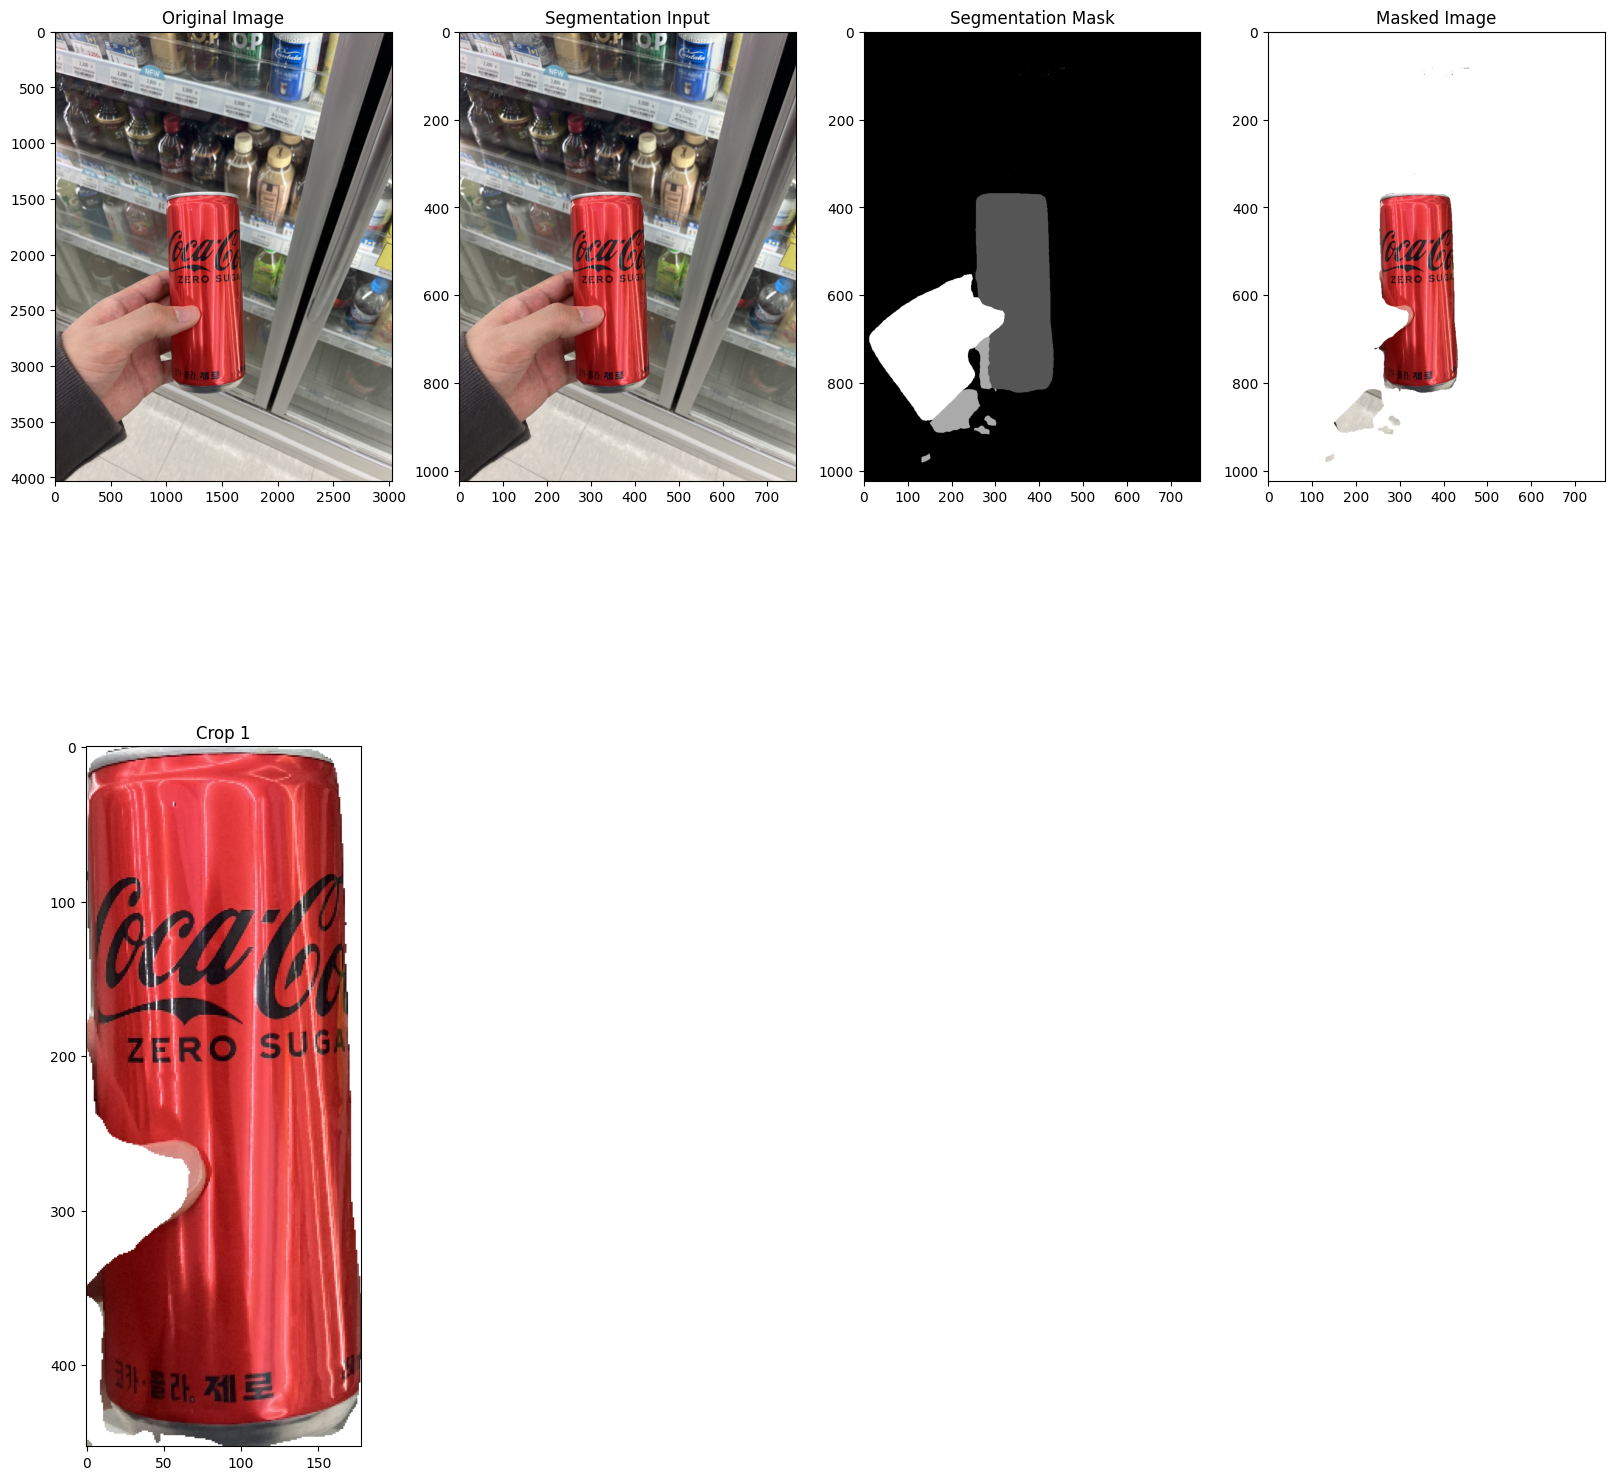

In [7]:
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# 이미지 로드 및 전처리
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((1024, 768)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    img_tensor = preprocess(img)
    img_resized = cv2.resize(img, (768, 1024)) 
    img_tensor = img_tensor.unsqueeze(0)  # 배치 차원 추가
    return img, img_tensor, img_resized

# 추론 함수
def predict(model, image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)['out'][0]
    output_predictions = output.argmax(0)
    return output_predictions.byte().cpu().numpy()

# 식별된 클래스 출력
def print_identified_classes(mask):
    unique_classes = np.unique(mask)
    for cls in unique_classes:
        print(f"Identified class: {CUSTOM_CLASSES[cls]}")

# 분할 결과 시각화
def visualize_result(img, mask, img_resized, masked_img, individual_crops):
    num_crops = len(individual_crops)
    plt.figure(figsize=(20, 20))
    plt.subplot(2, num_crops + 3, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.subplot(2, num_crops + 3, 2)
    plt.title("Segmentation Input")
    plt.imshow(img_resized)
    plt.subplot(2, num_crops + 3, 3)
    plt.title("Segmentation Mask")
    plt.imshow(mask, cmap='gray')
    plt.subplot(2, num_crops + 3, 4)
    plt.title("Masked Image")
    plt.imshow(masked_img)
    for i, crop in enumerate(individual_crops):
        plt.subplot(2, num_crops + 3, 5 + i)
        plt.title(f"Crop {i + 1}")
        plt.imshow(crop)
    plt.show()

# 마스크를 사용하여 이미지를 크롭하고 배경을 흰색으로 설정
def apply_mask(img, mask):
    masked_img = np.where((mask[..., None] == 0) | (mask[..., None] == 3), 255, img)
    return masked_img

# 같은 클래스의 객체 각각 크롭 및 작은 객체 제거
def crop_individual_objects(img_resized, mask, class_id, min_size=(50, 50)):
    labeled_mask, num_labels = label(mask == class_id)
    masked_img = apply_mask(img_resized, mask)  # 초기 마스크 처리된 이미지
    crops = []
    for i in range(1, num_labels + 1):
        y, x = np.where(labeled_mask == i)
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        if (x_max - x_min) >= min_size[0] and (y_max - y_min) >= min_size[1]:  # 최소 크기 필터링
            crop = masked_img[y_min:y_max, x_min:x_max]
            crops.append(crop)
        else:
            # 작은 객체를 백그라운드로 채우기
            mask[y_min:y_max, x_min:x_max] = 0
    masked_img = apply_mask(img_resized, mask)  # 작은 객체 제거 후 다시 마스크 처리
    return masked_img, crops

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUSTOM_CLASSES = ['background', 'drink', 'snack', 'Human_hand']

# 모델 준비
num_classes = len(CUSTOM_CLASSES)
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(512, num_classes, kernel_size=1)  # num_classes는 커스텀 데이터셋의 클래스 수
model = model.to(device)

# 모델 로드 및 GPU 설정
model_path = '/home/mmc/disk2/duck/cap/DeepLabV3+/pt/best_fcn50.pt'  # pt 파일 경로 지정
model.load_state_dict(torch.load(model_path))
model.eval()

image_path = '/home/mmc/disk2/duck/cap/data/drink_test/코카콜라제로225.jpg'  # 분할할 이미지 경로
img, img_tensor, img_resized = load_image(image_path)
mask = predict(model, img_tensor)

# 식별된 클래스 출력
print_identified_classes(mask)

masked_img, individual_crops = crop_individual_objects(img_resized, mask, class_id=1, min_size=(50, 50))

# 결과 시각화
visualize_result(img, mask, img_resized, masked_img, individual_crops)
